## Can we solve pen non-performance with algorithmic changes alone?

There are two possible reasons don't reach quotas. 
1. The annotators didn't get through all of the good images because the skip rate was too high
2. There weren't even enough good images served to them to reach the quota. 

To fix this issue. we need to identify the contribution of each of these kinds of issues

In [1]:
from aquabyte.data_access_utils import RDSAccessUtils
import json
import os

credentials = json.load(open(os.environ["DATA_WAREHOUSE_SQL_CREDENTIALS"]))
s3 = RDSAccessUtils(credentials)

get_annotation_data = """
SELECT * FROM prod.crop_annotation 
WHERE (captured_at BETWEEN '2019-10-01' AND '2019-12-01') AND 
(annotation_state_id IN (1, 3, 4, 6, 7)) AND
(service_id = 1);"""
annotation_data = s3.extract_from_database(get_annotation_data)

In [2]:
annotation_data.to_pickle('queued_and_annotated_images.pkl')

In [53]:
annotation_data2 = pd.read_pickle('queued_and_annotated_images.pkl')

KeyboardInterrupt: 

In [54]:
annotation_data.shape

(10671769, 19)

In [4]:
annotation_data.head()

,service_id,pen_id,annotation_state_id,base_key,url_key,right_crop_url,left_crop_metadata,right_crop_metadata,camera_metadata,annotation,captured_at,ts_source_start,ts_source_end,ts,annotator_email,skip_reasons,group_id,left_crop_url
0,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2533, 'height': 1458, 'x_coord': 777...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:13.718354+00:00,2019-10-01 00:00:58+00:00,NaT,2019-10-01 00:00:59.547000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....
1,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2106, 'height': 915, 'x_coord': 1989...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:13.718354+00:00,2019-10-01 00:00:58+00:00,2019-10-01 11:07:15+00:00,2019-10-01 11:24:59.805000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....
2,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2234, 'height': 957, 'x_coord': 1861...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:16.946055+00:00,2019-10-01 00:00:51+00:00,NaT,2019-10-01 00:00:52.064000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....
3,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2519, 'height': 1108, 'x_coord': 681...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:19.310888+00:00,2019-10-01 00:00:57+00:00,NaT,2019-10-01 00:00:57.584000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....
4,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2554, 'height': 1530, 'x_coord': 0, ...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:20.391090+00:00,2019-10-01 00:01:01+00:00,NaT,2019-10-01 00:01:02.258000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....


#### We use the captured_at field, because it links images submitted to the queue to their annotations

In [5]:
annotation_data['day_of_year'] = annotation_data['captured_at'].apply(lambda x: x.dayofyear)

### First, we want to get the days for which, for a given pen, Cogito has annotated all or almost all of the images served to them that day. To do that, we need both the number of images served that day, as well as the number of images annotated by Cogito that day.

In [6]:
queued = annotation_data[annotation_data['annotation_state_id'] == 1]
queued

,service_id,pen_id,annotation_state_id,base_key,url_key,right_crop_url,left_crop_metadata,right_crop_metadata,camera_metadata,annotation,captured_at,ts_source_start,ts_source_end,ts,annotator_email,skip_reasons,group_id,left_crop_url,day_of_year
0,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2533, 'height': 1458, 'x_coord': 777...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:13.718354+00:00,2019-10-01 00:00:58+00:00,NaT,2019-10-01 00:00:59.547000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....,274
1,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2106, 'height': 915, 'x_coord': 1989...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:13.718354+00:00,2019-10-01 00:00:58+00:00,2019-10-01 11:07:15+00:00,2019-10-01 11:24:59.805000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....,274
2,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2234, 'height': 957, 'x_coord': 1861...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:16.946055+00:00,2019-10-01 00:00:51+00:00,NaT,2019-10-01 00:00:52.064000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....,274
3,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2519, 'height': 1108, 'x_coord': 681...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:19.310888+00:00,2019-10-01 00:00:57+00:00,NaT,2019-10-01 00:00:57.584000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....,274
4,1,64,1,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 2554, 'height': 1530, 'x_coord': 0, ...",None,"{'baseline': 0.10153460486957998, 'focalLength...",None,2019-10-01 00:00:20.391090+00:00,2019-10-01 00:01:01+00:00,NaT,2019-10-01 00:01:02.258000+00:00,None,None,64,https://aquabyte-crops.s3.eu-west-1.amazonaws....,274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10671717,1,56,1,environment=production/site-id=39/pen-id=56/da...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{'width': 1510, 'height': 950, 'x_coord': 1248...","{'width': 1684, 'height': 1020, 'x_coord': 535...","{'baseline': 0.10148368515391534, 'focalLength...",None,2019-11-30 12:10:30.020864+00:00,2019-11-30 12:10:50+00:00,2019-12-02 08:36:37+00:00,2019-12-02 08:36:38.528000+00:00,None,None,56,https://aquabyte-crops.s3.eu-west-1.amazonaws....,334
10671718,1,56,1,environment=production/site-id=39/pen-id=56/da...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 1569, 'height': 839, 'x_coord': 1497...",None,"{'baseline': 0.10148368515391534, 'focalLength...",None,2019-11-30 13:16:36.708687+00:00,2019-11-30 13:16:47+00:00,2019-12-02 08:36:37+00:00,2019-12-02 08:36:38.674000+00:00,None,None,56,https://aquabyte-crops.s3.eu-west-1.amazonaws....,334
10671719,1,56,1,environment=production/site-id=39/pen-id=56/da...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{'width': 1594, 'height': 709, 'x_coord': 1505...","{'width': 1756, 'height': 750, 'x_coord': 746,...","{'baseline': 0.10148368515391534, 'focalLength...",None,2019-11-30 11:49:54.129710+00:00,2019-11-30 11:50:21+00:00,2019-12-02 08:36:37+00:00,2019-12-02 08:36:38.955000+00:00,None,None,56,https://aquabyte-crops.s3.eu-west-1.amazonaws....,334
10671720,1,56,1,environment=production/site-id=39/pen-id=56/da...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 1377, 'height': 632, 'x_coord': 290,...",None,"{'baseline': 0.10148368515391534, 'focalLength...",None,2019-11-30 11:51:3

In [7]:
total_queued = queued.groupby(['pen_id', 'day_of_year'])['left_crop_metadata'].aggregate('count')
total_queued

pen_id  day_of_year
23      332                0
        333              362
        334             1178
37      274             1336
        275               38
                       ...  
75      320            11235
        321             7090
        322             3105
        323               34
        324              124
Name: left_crop_metadata, Length: 634, dtype: int64

In [8]:
total_queued = total_queued.unstack('pen_id')
total_queued = total_queued.fillna(0)
total_queued

pen_id,23,37,40,56,57,58,59,60,61,62,63,64,65,66,67,69,71,72,73,75
day_of_year,,,,,,,,,,,,,,,,,,,,
274,0.0,1336.0,6846.0,20607.0,11058.0,15290.0,23806.0,28076.0,11858.0,0.0,1274.0,33778.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,0.0,38.0,8239.0,19676.0,3494.0,15032.0,26341.0,24932.0,16442.0,0.0,3903.0,42424.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276,0.0,862.0,7144.0,21763.0,6146.0,13078.0,29025.0,28324.0,27548.0,0.0,4594.0,43860.0,381.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277,0.0,1182.0,5830.0,25386.0,22117.0,28502.0,25947.0,31071.0,27415.0,0.0,5433.0,44922.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
278,0.0,1107.0,4490.0,22310.0,15926.0,25150.0,28220.0,27280.0,4041.0,0.0,6092.0,56943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.0,1730.0,0.0,0.0,2819.0,0.0,1685.0,3050.0,3221.0,0.0,0.0,972.0,2417.0,25.0,0.0,0.0,0.0,1076.0,0.0,0.0
331,0.0,2066.0,0.0,1061.0,7064.0,525.0,6920.0,9138.0,4779.0,0.0,0.0,3003.0,2287.0,28.0,0.0,0.0,0.0,357.0,0.0,0.0
332,0.0,2243.0,0.0,4022.0,6517.0,659.0,5994.0,5690.0,5895.0,0.0,0.0,6764.0,1282.0,56.0,0.0,0.0,0.0,2058.0,0.0,0.0


In [9]:
annotations = annotation_data[annotation_data['annotation_state_id'].isin([3,4])]

#### cleaning: according to princeton, there's a race condition where in a very small proportion of images they're served to two annotators (when they refresh at the same time before the queue is updated by one of them)

In [10]:
annotations.drop_duplicates(subset='left_crop_url', inplace=True)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
total_annotated = annotations.groupby(['pen_id', 'day_of_year'])['left_crop_metadata'].aggregate('count')
total_annotated = total_annotated.unstack('pen_id')
total_annotated = total_annotated.fillna(0)
total_annotated

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,73,75
day_of_year,,,,,,,,,,,,,,,,
274,1310.0,1882.0,2175.0,2566.0,2280.0,2140.0,2127.0,0.0,1266.0,3809.0,0.0,0.0,0.0,0.0,0.0,0.0
275,38.0,2492.0,2624.0,2098.0,4654.0,3035.0,4314.0,0.0,2368.0,704.0,0.0,0.0,0.0,0.0,0.0,0.0
276,857.0,3413.0,2345.0,1410.0,1988.0,1103.0,2807.0,0.0,3194.0,5836.0,0.0,0.0,0.0,0.0,0.0,0.0
277,1182.0,5830.0,4076.0,1932.0,5805.0,4098.0,3876.0,0.0,158.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0
278,1105.0,4490.0,2630.0,2172.0,2374.0,2728.0,1319.0,0.0,1082.0,862.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,1729.0,0.0,0.0,2819.0,0.0,1551.0,1363.0,0.0,0.0,585.0,2417.0,25.0,0.0,0.0,0.0,0.0
331,2065.0,0.0,1061.0,7064.0,525.0,3596.0,2205.0,0.0,0.0,854.0,2286.0,28.0,0.0,0.0,0.0,0.0
332,2242.0,0.0,4022.0,6517.0,659.0,2590.0,3831.0,0.0,0.0,0.0,1282.0,56.0,0.0,0.0,0.0,0.0


##### Make sure we have all the same pens and days

In [12]:
assert set(total_queued.index) == set(total_annotated.index)

In [13]:
all_queue_cols = set(total_queued.columns)
all_ann_cols = set(total_annotated.columns)

assert all_ann_cols == all_queue_cols, all_queue_cols - all_ann_cols

AssertionError: {67, 23, 61, 71}

#### Okay, so there are some pens for which we never serve images to annotators, let's filter those out

In [14]:
total_queued = total_queued[total_annotated.columns]
assert set(total_queued.columns) == set(total_annotated.columns)
total_queued

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,73,75
day_of_year,,,,,,,,,,,,,,,,
274,1336.0,6846.0,20607.0,11058.0,15290.0,23806.0,28076.0,0.0,1274.0,33778.0,0.0,0.0,0.0,0.0,0.0,0.0
275,38.0,8239.0,19676.0,3494.0,15032.0,26341.0,24932.0,0.0,3903.0,42424.0,0.0,0.0,0.0,0.0,0.0,0.0
276,862.0,7144.0,21763.0,6146.0,13078.0,29025.0,28324.0,0.0,4594.0,43860.0,381.0,0.0,0.0,0.0,0.0,0.0
277,1182.0,5830.0,25386.0,22117.0,28502.0,25947.0,31071.0,0.0,5433.0,44922.0,0.0,1.0,0.0,0.0,0.0,0.0
278,1107.0,4490.0,22310.0,15926.0,25150.0,28220.0,27280.0,0.0,6092.0,56943.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,1730.0,0.0,0.0,2819.0,0.0,1685.0,3050.0,0.0,0.0,972.0,2417.0,25.0,0.0,1076.0,0.0,0.0
331,2066.0,0.0,1061.0,7064.0,525.0,6920.0,9138.0,0.0,0.0,3003.0,2287.0,28.0,0.0,357.0,0.0,0.0
332,2243.0,0.0,4022.0,6517.0,659.0,5994.0,5690.0,0.0,0.0,6764.0,1282.0,56.0,0.0,2058.0,0.0,0.0


In [15]:
pct_unannotated = (total_queued - total_annotated) / total_queued
pct_unannotated = pct_unannotated[pct_unannotated.notnull()]
pct_unannotated

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,73,75
day_of_year,,,,,,,,,,,,,,,,
274,0.019461,0.725095,0.894453,0.767951,0.850883,0.910107,0.924241,NaN,0.006279,0.887234,NaN,NaN,NaN,NaN,NaN,NaN
275,0.000000,0.697536,0.866640,0.399542,0.690394,0.884780,0.826969,NaN,0.393287,0.983406,NaN,NaN,NaN,NaN,NaN,NaN
276,0.005800,0.522256,0.892248,0.770582,0.847989,0.961998,0.900897,NaN,0.304745,0.866940,1.000000,NaN,NaN,NaN,NaN,NaN
277,0.000000,0.000000,0.839439,0.912646,0.796330,0.842063,0.875253,NaN,0.970918,0.994835,NaN,1.0,NaN,NaN,NaN,NaN
278,0.001807,0.000000,0.882116,0.863619,0.905606,0.903331,0.951650,NaN,0.822390,0.984862,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.000578,NaN,NaN,0.000000,NaN,0.079525,0.553115,NaN,NaN,0.398148,0.000000,0.0,NaN,1.0,NaN,NaN
331,0.000484,NaN,0.000000,0.000000,0.000000,0.480347,0.758700,NaN,NaN,0.715618,0.000437,0.0,NaN,1.0,NaN,NaN
332,0.000446,NaN,0.000000,0.000000,0.000000,0.567901,0.326714,NaN,NaN,1.000000,0.000000,0.0,NaN,1.0,NaN,NaN


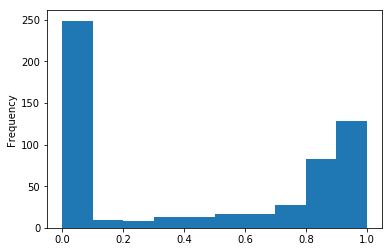

In [18]:
import pandas as pd

all_pcts = pd.Series(pct_unannotated.values.flatten())

all_pcts.plot.hist()

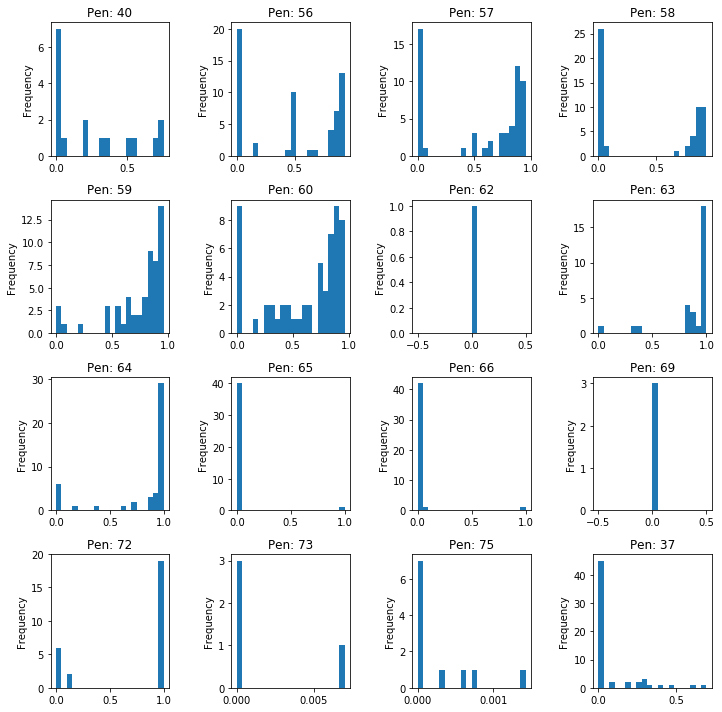

In [76]:
import matplotlib.pyplot as plt

ncols = 4
fig, axes = plt.subplots(nrows=(len(pct_unannotated.columns) // ncols), ncols=ncols, figsize=(10, 10))

for i, pen in enumerate(pct_unannotated.columns):
    ax = axes[row][col] 
    col = i % ncols
    row = i // ncols
    pct_unannotated[pen].plot.hist(ax=ax, bins=20)
    ax.set_title(f'Pen: {pen}')
plt.tight_layout()

### Okay, great, the issue is fixed

## Now let's group days into different thresholds on the proportion annotated

### We also need the number of images sent to QA for a given day, to get a sense of how close we are to meeting the quota

In [19]:
qa_annotations = annotations[annotations['annotation_state_id'] == 3]

total_qa = qa_annotations.groupby(['pen_id', 'day_of_year'])['left_crop_url'].aggregate('count')
total_qa = total_qa.unstack(level='pen_id')
total_qa

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,75
day_of_year,,,,,,,,,,,,,,,
274,NaN,162.0,138.0,98.0,328.0,265.0,470.0,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN
275,NaN,192.0,304.0,81.0,513.0,556.0,1017.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
276,38.0,319.0,352.0,96.0,314.0,171.0,662.0,NaN,19.0,3.0,NaN,NaN,NaN,NaN,NaN
277,29.0,206.0,605.0,319.0,1033.0,753.0,1001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278,39.0,142.0,400.0,327.0,486.0,587.0,384.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,39.0,NaN,NaN,303.0,NaN,293.0,144.0,NaN,NaN,15.0,39.0,NaN,NaN,NaN,NaN
331,37.0,NaN,88.0,455.0,33.0,713.0,157.0,NaN,NaN,24.0,60.0,NaN,NaN,NaN,NaN
332,22.0,NaN,406.0,413.0,32.0,399.0,360.0,NaN,NaN,NaN,20.0,1.0,NaN,NaN,NaN


In [20]:
total_qa = total_qa.fillna(0)
total_qa

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,75
day_of_year,,,,,,,,,,,,,,,
274,0.0,162.0,138.0,98.0,328.0,265.0,470.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0
275,0.0,192.0,304.0,81.0,513.0,556.0,1017.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
276,38.0,319.0,352.0,96.0,314.0,171.0,662.0,0.0,19.0,3.0,0.0,0.0,0.0,0.0,0.0
277,29.0,206.0,605.0,319.0,1033.0,753.0,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278,39.0,142.0,400.0,327.0,486.0,587.0,384.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,39.0,0.0,0.0,303.0,0.0,293.0,144.0,0.0,0.0,15.0,39.0,0.0,0.0,0.0,0.0
331,37.0,0.0,88.0,455.0,33.0,713.0,157.0,0.0,0.0,24.0,60.0,0.0,0.0,0.0,0.0
332,22.0,0.0,406.0,413.0,32.0,399.0,360.0,0.0,0.0,0.0,20.0,1.0,0.0,0.0,0.0


In [21]:
qa_cols = set(total_qa.columns)
ann_cols = set(total_annotated.columns)
assert qa_cols == ann_cols, ann_cols - qa_cols

AssertionError: {73}

##### Not one qa for pen 73, so let's filter that one.

In [22]:
total_annotated = total_annotated[total_qa.columns]
total_queued = total_queued[total_qa.columns]
assert (set(total_queued.columns) == set(total_annotated.columns)) and (set(total_annotated.columns) == set(total_qa.columns))

In [23]:
all_pens = total_queued.columns

### Ok now let's get some plots that tell is exactly where and when we're non-performing

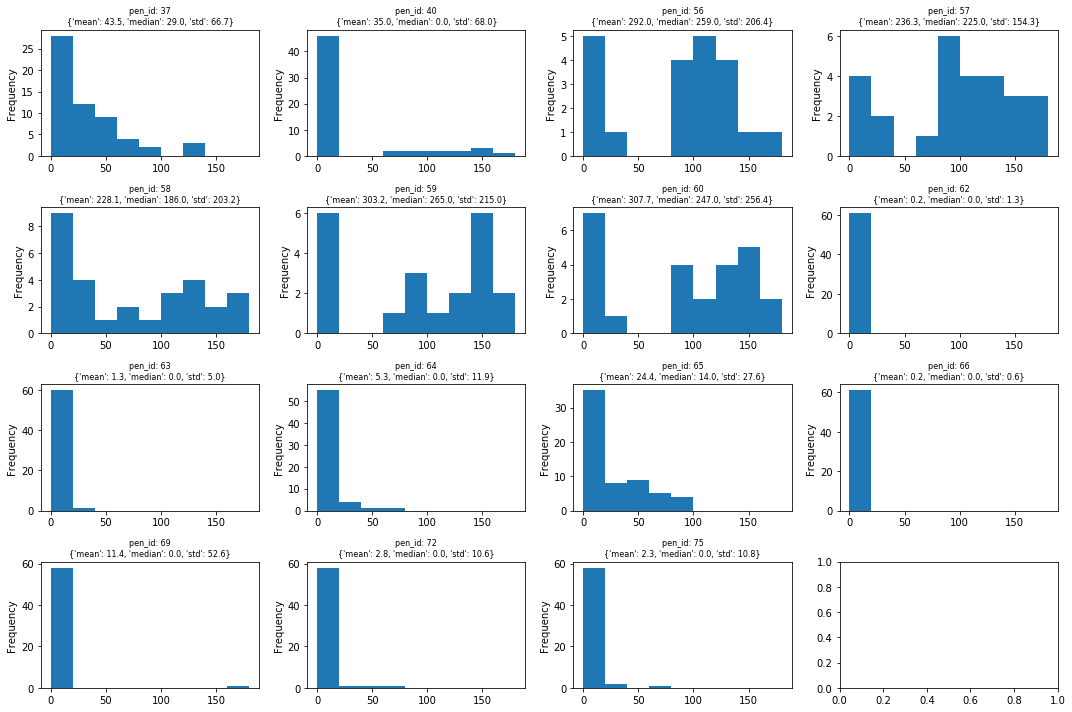

In [26]:
import matplotlib.pyplot as plt

ncols = 4
fig, axes = plt.subplots(nrows=(len(all_pens) // ncols)+1, ncols=ncols, figsize=(15, 10))

for i, pen_id in enumerate(all_pens):
    col, row = i % ncols, i // ncols
    ax = axes[row][col]
    this_pen_qa = total_qa[pen_id]
    metrics = {metric: round(getattr(this_pen_qa, metric)(), 1) for metric in ['mean', 'median', 'std']}
    this_pen_qa.plot.hist(bins=range(0, 200, 20), ax=ax)
    ax.set_title(f'pen_id: {pen_id}\n{metrics}', size=8)
plt.tight_layout()

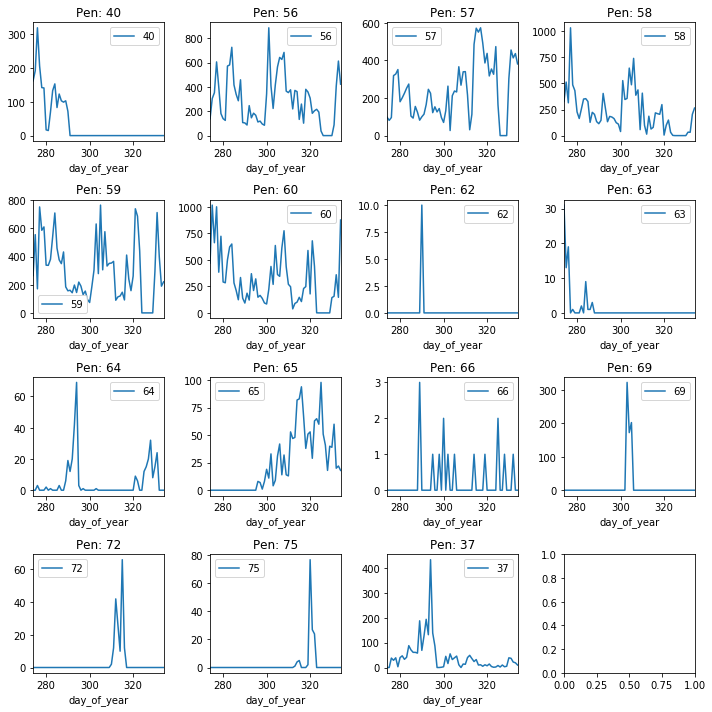

In [27]:
ncols = 4
fig, axes = plt.subplots(nrows=(len(all_pens) // ncols)+1, ncols=ncols, figsize=(10, 10))

for i, pen_id in enumerate(all_pens):
    ax = axes[row][col]
    col, row = i % ncols, i // ncols
    total_qa.plot(y=pen_id, ax=ax)
    ax.set_title(f'Pen: {pen_id}')
plt.tight_layout()

### Metrics

#### Now that we have this data, let's calculate two metrics

1. The proportion of missed quota days that Cogito annotated most of the images for. This will tell us a lower bound for how many days in the past we could not have made reach the quota with better algorithms post-cropper, for each pen.
2. Of days Cogito annotated the full backlog, what proportion missed the quota. This tells us the probability that on a day where Cogito is able to annotate everything that we still don't reach the quota.

In [28]:
total_qa

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,75
day_of_year,,,,,,,,,,,,,,,
274,0.0,162.0,138.0,98.0,328.0,265.0,470.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0
275,0.0,192.0,304.0,81.0,513.0,556.0,1017.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
276,38.0,319.0,352.0,96.0,314.0,171.0,662.0,0.0,19.0,3.0,0.0,0.0,0.0,0.0,0.0
277,29.0,206.0,605.0,319.0,1033.0,753.0,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278,39.0,142.0,400.0,327.0,486.0,587.0,384.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,39.0,0.0,0.0,303.0,0.0,293.0,144.0,0.0,0.0,15.0,39.0,0.0,0.0,0.0,0.0
331,37.0,0.0,88.0,455.0,33.0,713.0,157.0,0.0,0.0,24.0,60.0,0.0,0.0,0.0,0.0
332,22.0,0.0,406.0,413.0,32.0,399.0,360.0,0.0,0.0,0.0,20.0,1.0,0.0,0.0,0.0


In [29]:
pct_unannotated

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,73,75
day_of_year,,,,,,,,,,,,,,,,
274,0.019461,0.725095,0.894453,0.767951,0.850883,0.910107,0.924241,NaN,0.006279,0.887234,NaN,NaN,NaN,NaN,NaN,NaN
275,0.000000,0.697536,0.866640,0.399542,0.690394,0.884780,0.826969,NaN,0.393287,0.983406,NaN,NaN,NaN,NaN,NaN,NaN
276,0.005800,0.522256,0.892248,0.770582,0.847989,0.961998,0.900897,NaN,0.304745,0.866940,1.000000,NaN,NaN,NaN,NaN,NaN
277,0.000000,0.000000,0.839439,0.912646,0.796330,0.842063,0.875253,NaN,0.970918,0.994835,NaN,1.0,NaN,NaN,NaN,NaN
278,0.001807,0.000000,0.882116,0.863619,0.905606,0.903331,0.951650,NaN,0.822390,0.984862,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.000578,NaN,NaN,0.000000,NaN,0.079525,0.553115,NaN,NaN,0.398148,0.000000,0.0,NaN,1.0,NaN,NaN
331,0.000484,NaN,0.000000,0.000000,0.000000,0.480347,0.758700,NaN,NaN,0.715618,0.000437,0.0,NaN,1.0,NaN,NaN
332,0.000446,NaN,0.000000,0.000000,0.000000,0.567901,0.326714,NaN,NaN,1.000000,0.000000,0.0,NaN,1.0,NaN,NaN


##### The proportion of missed quota days that Cogito annotated most of the images for. 

In [77]:
proportion_missed_annotated_most = dict()
proportion_annotated_most_missed = dict()

for pen in all_pens:
    this_pen_qa = total_qa[pen]
    missed_quota = this_pen_qa[this_pen_qa < 50]
    missed_quota_days = missed_quota.index
    this_pen_unannotated = pct_unannotated[pen]
    proportion_missed_annotated_most[pen] = dict()
    proportion_annotated_most_missed[pen] = dict()
    for threshold in [0, 0.01, 0.1, 0.5]:
        
        annotated_most = this_pen_unannotated[this_pen_unannotated <= threshold]
        annotated_most_days = pd.Series(annotated_most.index)
        if len(annotated_most_days):
        
            # Metric 1 calculation
            missed_annotated_most_days = annotated_most_days[annotated_most_days.isin(missed_quota_days)]
            proportion_missed_annotated_most[pen][threshold] = len(missed_annotated_most_days) / len(missed_quota_days)
            
            # Metric 2 calculation
            annotated_most_missed_days = missed_quota_days[missed_quota_days.isin(annotated_most_days)]
            proportion_annotated_most_missed[pen][threshold] = len(annotated_most_missed_days) / len(annotated_most_days)

In [78]:
df = pd.DataFrame.from_dict(proportion_missed_annotated_most)
df.columns.name = 'pen_id'
df.index.name = 'annotated most threshold'
df

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,75
annotated most threshold,,,,,,,,,,,,,,,
0.00,0.638298,0.000000,0.666667,0.166667,0.461538,0.0,0.375,0.016393,NaN,0.016667,0.354167,0.508197,0.0,0.033333,0.116667
0.01,0.872340,0.000000,0.666667,0.166667,0.461538,0.0,0.375,0.016393,0.016393,0.066667,0.562500,0.606557,0.0,0.083333,0.166667
0.10,0.914894,0.021739,0.666667,0.166667,0.461538,0.0,0.375,0.016393,0.016393,0.100000,0.562500,0.704918,0.0,0.083333,0.166667
0.50,0.936170,0.021739,0.666667,0.166667,0.461538,0.0,0.375,0.016393,0.049180,0.133333,0.562500,0.704918,0.0,0.116667,0.166667


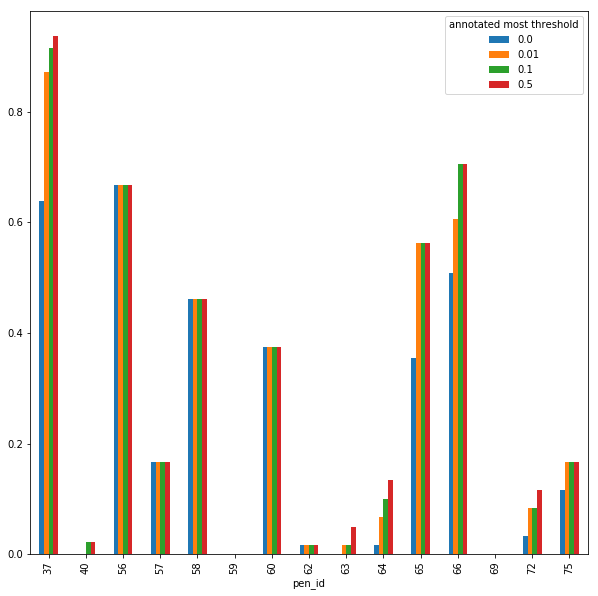

In [79]:
df.T.plot.bar(figsize=(10, 10))

In [80]:
df = pd.DataFrame.from_dict(proportion_annotated_most_missed)
df.columns.name = 'pen_id'
df.index.name = 'annotated most threshold'
df

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,75
annotated most threshold,,,,,,,,,,,,,,,
0.00,1.000000,0.000000,0.235294,0.111111,0.333333,0.0,0.500000,1.0,NaN,1.0,0.653846,1.0,0.0,1.000000,1.000000
0.01,0.931818,0.000000,0.200000,0.058824,0.230769,0.0,0.333333,1.0,1.0,1.0,0.675000,1.0,0.0,0.833333,0.909091
0.10,0.914894,0.125000,0.200000,0.055556,0.214286,0.0,0.333333,1.0,1.0,1.0,0.675000,1.0,0.0,0.833333,0.909091
0.50,0.771930,0.083333,0.142857,0.050000,0.214286,0.0,0.157895,1.0,1.0,1.0,0.675000,1.0,0.0,0.875000,0.909091


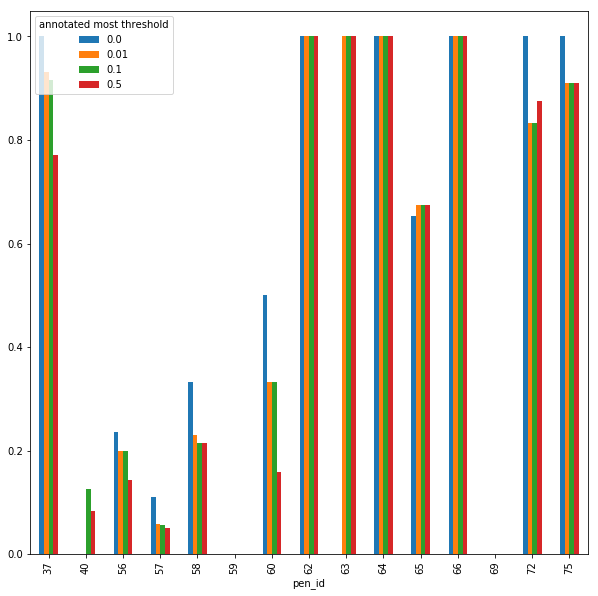

In [81]:
df.T.plot.bar(figsize=(10, 10))

## What if we define Quota failure as <150 images instead of <50 images, since QA accepts ~30-70% of images. 

In [82]:
proportion_missed_annotated_most = dict()
proportion_annotated_most_missed = dict()

for pen in all_pens:
    this_pen_qa = total_qa[pen]
    missed_quota = this_pen_qa[this_pen_qa < 150]
    missed_quota_days = missed_quota.index
    this_pen_unannotated = pct_unannotated[pen]
    proportion_missed_annotated_most[pen] = dict()
    proportion_annotated_most_missed[pen] = dict()
    for threshold in [0, 0.01, 0.1, 0.5]:
        
        annotated_most = this_pen_unannotated[this_pen_unannotated <= threshold]
        annotated_most_days = pd.Series(annotated_most.index)
        if len(annotated_most_days):
        
            # Metric 1 calculation
            missed_annotated_most_days = annotated_most_days[annotated_most_days.isin(missed_quota_days)]
            proportion_missed_annotated_most[pen][threshold] = len(missed_annotated_most_days) / len(missed_quota_days)
            
            # Metric 2 calculation
            annotated_most_missed_days = missed_quota_days[missed_quota_days.isin(annotated_most_days)]
            proportion_annotated_most_missed[pen][threshold] = len(annotated_most_missed_days) / len(annotated_most_days)

In [83]:
df = pd.DataFrame.from_dict(proportion_missed_annotated_most)
df.columns.name = 'pen_id'
df.index.name = 'annotated most threshold'
df

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,75
annotated most threshold,,,,,,,,,,,,,,,
0.00,0.517241,0.035714,0.35,0.045455,0.384615,0.0000,0.136364,0.016393,NaN,0.016393,0.426230,0.508197,0.0,0.032787,0.114754
0.01,0.758621,0.089286,0.35,0.045455,0.461538,0.0000,0.181818,0.016393,0.016393,0.065574,0.655738,0.606557,0.0,0.098361,0.180328
0.10,0.810345,0.125000,0.35,0.045455,0.461538,0.0000,0.181818,0.016393,0.016393,0.098361,0.655738,0.704918,0.0,0.098361,0.180328
0.50,0.931034,0.178571,0.35,0.090909,0.461538,0.0625,0.272727,0.016393,0.049180,0.131148,0.655738,0.704918,0.0,0.131148,0.180328


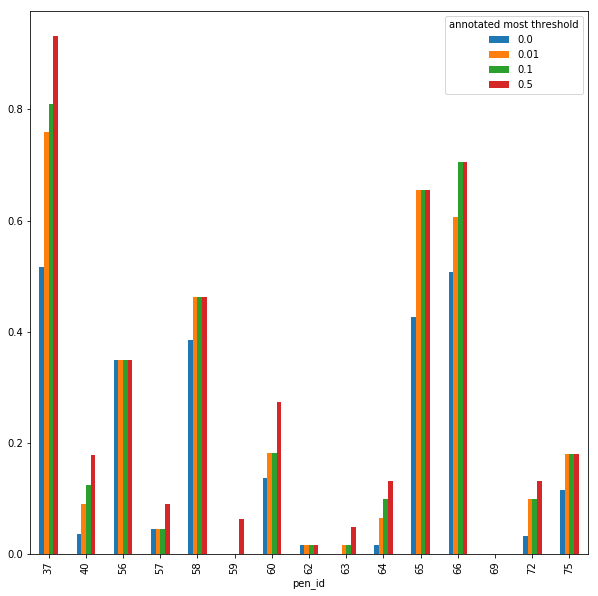

In [84]:
df.T.plot.bar(figsize=(10, 10))

In [80]:
df = pd.DataFrame.from_dict(proportion_annotated_most_missed)
df.columns.name = 'pen_id'
df.index.name = 'annotated most threshold'
df

pen_id,37,40,56,57,58,59,60,62,63,64,65,66,69,72,75
annotated most threshold,,,,,,,,,,,,,,,
0.00,1.000000,0.000000,0.235294,0.111111,0.333333,0.0,0.500000,1.0,NaN,1.0,0.653846,1.0,0.0,1.000000,1.000000
0.01,0.931818,0.000000,0.200000,0.058824,0.230769,0.0,0.333333,1.0,1.0,1.0,0.675000,1.0,0.0,0.833333,0.909091
0.10,0.914894,0.125000,0.200000,0.055556,0.214286,0.0,0.333333,1.0,1.0,1.0,0.675000,1.0,0.0,0.833333,0.909091
0.50,0.771930,0.083333,0.142857,0.050000,0.214286,0.0,0.157895,1.0,1.0,1.0,0.675000,1.0,0.0,0.875000,0.909091


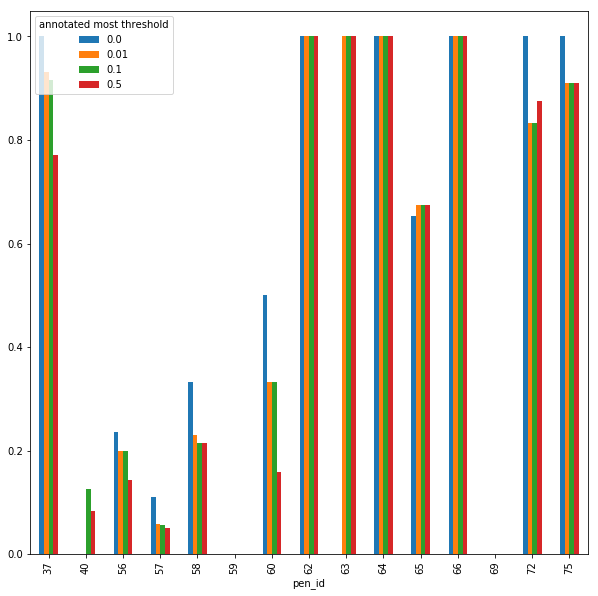

In [81]:
df.T.plot.bar(figsize=(10, 10))